# Energy Theft Detection using image transformation technique and tiled convolutional neural network

[Reference]
Encoding Time Series as Images for Visual Inspection and Classification Using Tiled Convolutional Neural Networks, ZhiguangWang and Tim Oates, Trajectory-Based Behavior Analytics: Papers from the 2015 AAAI Workshop, 2015.

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read data
df = pd.read_csv("data.csv", index_col=0)
df

,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
CONS_NO,,,,,,,,,,,,,,,,,,,,,
0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.12,9.96,16.92,7.60,27.22,18.05,26.47,18.75,17.84,14.92
01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.50,9.99,11.78,18.59,26.80,18.57,14.59,12.82,19.37,15.92
EDFC78B07BA2908B3395C4EB2304665E,1,2.90,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,...,17.77,10.37,15.32,13.51,12.23,14.68,16.35,18.14,18.41,17.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F1472871E1AFF49D4289564B6377D76C,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.25,3.56,3.38,4.39,3.72,3.77,3.96,3.64,3.40,4.38
F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,2.70,4.39,3.95,0.00,0.00,0.00,0.00,0.00,0.00,...,4.81,4.87,4.48,3.67,3.31,4.58,3.33,3.19,4.57,4.00
A9A0FE83467A680FBFB0DBFC910DF227,0,0.58,0.84,1.61,0.90,0.60,0.82,0.89,0.03,0.73,...,NaN,0.66,2.92,2.36,3.86,4.28,3.37,6.67,2.44,1.15


In [3]:
# Check missing values
df.isnull().sum(axis=1).value_counts() / df.shape[1]

730    5.196135
1      1.434783
5      1.323671
3      1.044444
732    0.895652
         ...   
634    0.000966
992    0.000966
788    0.000966
850    0.000966
687    0.000966
Name: count, Length: 915, dtype: float64

<Axes: xlabel='ratio of NA', ylabel='number of consumers'>

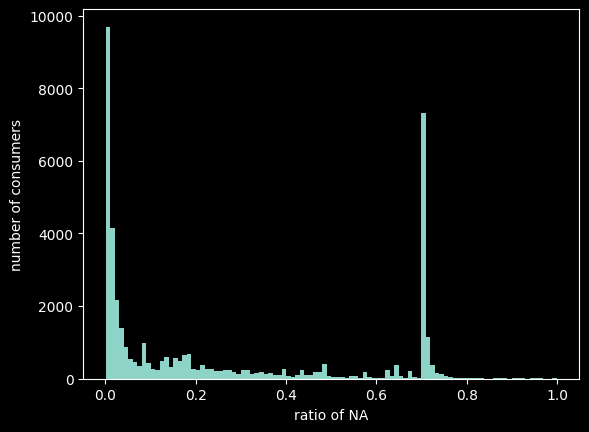

In [4]:
# Display histogram of the number of missing values in each row (across all columns)
na_ratio = df.isnull().sum(axis=1) / df.shape[1]
na_ratio.plot(kind='hist', xlabel='ratio of NA', ylabel='number of consumers', bins=100)


In [5]:
# Check the ratio of 'FLAG' - 1: Abnormal(Energy Theft), 0: Normal
print(df['FLAG'].sum())
print(df['FLAG'].sum() / df.shape[0])

3615
0.08531577456811101


In [6]:
# Remove rows with more than 35 percent missing values
df = df[(df.isnull().sum(axis=1) / df.shape[1]) < 0.35]
print(df.shape)

(28949, 1035)


In [7]:
# Remove rows which have 0 values but 'FLAG'
df = df[df.iloc[:, :-1].sum(axis=1) > 0.0]
print(df.shape)

(27784, 1035)


In [8]:
print(df['FLAG'].sum())
print(df['FLAG'].sum() / df.shape[0])

2166
0.07795853728764757


In [9]:
df_flag = df['FLAG']
df = df.drop(['FLAG'], axis=1)
df_flag

CONS_NO
EDFC78B07BA2908B3395C4EB2304665E    1
34C1954AA3703C4F8BD8EAEA7C4B7B83    1
768309B0EB11FD436CEE5ABFB84F4C0C    1
516954F5FF177CE314656D727FCC66A5    1
E34D1B467A365835A4A8AAD9395D49AA    1
                                   ..
5FCE503B6B616D5023B3C46173383107    0
F1472871E1AFF49D4289564B6377D76C    0
F3C8BBCD2DC26C1E0249DEEF6A4256B7    0
A9A0FE83467A680FBFB0DBFC910DF227    0
D9A6ADA018FA46A55D5438370456AA45    0
Name: FLAG, Length: 27784, dtype: int64

In [10]:
# remove rows where sum values is 0
df = df[df.sum(axis=1)!=0]

In [11]:
df = df.T

In [12]:
df.index = pd.to_datetime(df.index)

In [13]:
df

CONS_NO,EDFC78B07BA2908B3395C4EB2304665E,34C1954AA3703C4F8BD8EAEA7C4B7B83,768309B0EB11FD436CEE5ABFB84F4C0C,516954F5FF177CE314656D727FCC66A5,E34D1B467A365835A4A8AAD9395D49AA,9F61C13255D1183B179753742A24BFAD,F1D26619E4BC428924BAF5261F705D18,EB2DCE9143BF42A1C7E5E218BB77B6A6,E89F2AD4B103F2E2045EE0F4E60429BC,441D4A577AAD02F6C003644640C2619C,...,2A32029199A137504FB925D214AF20E9,1C6A4E84B6CE1105A01EECC4955FE4AC,9B3DC5E19AC7BE97FBE1A65F4A115CC4,1DF750822A991C356E86556CF5A64955,8C864A692CC5840072CF3BEBDA3CA8DB,5FCE503B6B616D5023B3C46173383107,F1472871E1AFF49D4289564B6377D76C,F3C8BBCD2DC26C1E0249DEEF6A4256B7,A9A0FE83467A680FBFB0DBFC910DF227,D9A6ADA018FA46A55D5438370456AA45
2014-01-01,2.90,0.11,0.91,11.02,NaN,1.91,5.20,0.00,6.03,19.92,...,NaN,NaN,148.40,0.00,5.22,NaN,NaN,2.70,0.58,16.89
2014-01-10,3.42,0.53,0.86,8.24,NaN,1.82,8.03,0.00,7.29,0.00,...,NaN,NaN,174.02,0.00,0.00,NaN,NaN,4.39,0.84,13.84
2014-01-11,3.81,0.45,1.10,7.94,NaN,1.07,8.11,0.00,4.86,0.00,...,NaN,NaN,122.26,0.00,15.96,NaN,NaN,3.95,1.61,13.50
2014-01-12,4.58,0.51,0.66,7.92,NaN,1.33,2.47,0.00,8.85,12.68,...,NaN,NaN,133.16,0.00,14.53,NaN,NaN,0.00,0.90,14.60
2014-01-13,3.56,1.32,5.82,8.31,NaN,1.97,1.51,0.00,5.73,15.48,...,NaN,NaN,173.65,0.00,15.43,NaN,NaN,0.00,0.60,14.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-05,14.68,1.36,4.61,108.69,5.81,15.18,15.56,0.00,12.25,13.54,...,3.92,13.08,283.51,1.83,4.75,1.29,3.77,4.58,4.28,18.11
2016-09-06,16.35,0.56,3.13,87.88,4.61,21.83,15.82,0.00,1.33,13.25,...,2.99,10.90,303.76,1.39,6.94,0.67,3.96,3.33,3.37,19.31
2016-09-07,18.14,1.02,3.10,86.36,4.78,24.30,14.67,0.32,0.08,14.18,...,5.00,11.57,285.34,7.50,4.55,0.76,3.64,3.19,6.67,17.48
2016-09-08,18.41,1.96,3.74,81.51,4.21,11.58,17.46,0.00,0.15,12.92,...,6.12,10.90,282.57,4.40,6.12,1.16,3.40,4.57,2.44,17.20


In [14]:
df = df.sort_index()
df

CONS_NO,EDFC78B07BA2908B3395C4EB2304665E,34C1954AA3703C4F8BD8EAEA7C4B7B83,768309B0EB11FD436CEE5ABFB84F4C0C,516954F5FF177CE314656D727FCC66A5,E34D1B467A365835A4A8AAD9395D49AA,9F61C13255D1183B179753742A24BFAD,F1D26619E4BC428924BAF5261F705D18,EB2DCE9143BF42A1C7E5E218BB77B6A6,E89F2AD4B103F2E2045EE0F4E60429BC,441D4A577AAD02F6C003644640C2619C,...,2A32029199A137504FB925D214AF20E9,1C6A4E84B6CE1105A01EECC4955FE4AC,9B3DC5E19AC7BE97FBE1A65F4A115CC4,1DF750822A991C356E86556CF5A64955,8C864A692CC5840072CF3BEBDA3CA8DB,5FCE503B6B616D5023B3C46173383107,F1472871E1AFF49D4289564B6377D76C,F3C8BBCD2DC26C1E0249DEEF6A4256B7,A9A0FE83467A680FBFB0DBFC910DF227,D9A6ADA018FA46A55D5438370456AA45
2014-01-01,2.90,0.11,0.91,11.02,NaN,1.91,5.20,0.00,6.03,19.92,...,NaN,NaN,148.40,0.00,5.22,NaN,NaN,2.70,0.58,16.89
2014-01-02,5.64,0.11,1.16,7.92,NaN,2.11,2.35,0.00,3.18,14.81,...,NaN,NaN,159.86,0.00,5.04,NaN,NaN,0.00,1.16,15.15
2014-01-03,6.99,0.25,0.75,8.41,NaN,1.69,2.56,0.01,3.33,13.11,...,NaN,NaN,157.20,0.00,4.92,NaN,NaN,0.00,0.92,19.28
2014-01-04,3.32,0.27,1.30,9.66,NaN,1.72,1.46,0.00,7.26,14.51,...,NaN,NaN,104.80,0.00,4.88,NaN,NaN,5.72,0.98,17.19
2014-01-05,3.61,0.21,0.74,9.86,NaN,1.31,2.04,0.00,6.36,15.43,...,NaN,NaN,118.17,0.00,13.59,NaN,NaN,6.05,1.54,16.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-10-27,6.73,1.18,3.82,57.22,4.59,12.22,15.89,0.89,0.00,11.65,...,8.60,11.85,236.22,2.50,6.78,0.82,2.83,4.64,0.51,11.15
2016-10-28,7.52,1.13,2.75,56.68,4.71,16.39,13.00,0.35,0.26,10.96,...,4.23,11.46,243.06,2.74,7.83,0.65,2.54,3.71,0.79,12.22
2016-10-29,10.89,1.34,2.96,45.28,5.62,12.14,14.80,0.38,0.45,13.34,...,3.54,8.98,114.47,4.55,14.42,0.53,3.40,6.22,0.66,13.16
2016-10-30,9.86,1.26,3.67,44.04,6.83,10.82,14.91,0.70,0.36,9.91,...,3.26,9.95,115.52,3.76,9.58,0.77,3.59,6.05,0.39,13.33


In [15]:
# interpolate missing values
df.interpolate(limit_direction="both",inplace=True)

In [16]:
df.isnull().sum()

CONS_NO
EDFC78B07BA2908B3395C4EB2304665E    0
34C1954AA3703C4F8BD8EAEA7C4B7B83    0
768309B0EB11FD436CEE5ABFB84F4C0C    0
516954F5FF177CE314656D727FCC66A5    0
E34D1B467A365835A4A8AAD9395D49AA    0
                                   ..
5FCE503B6B616D5023B3C46173383107    0
F1472871E1AFF49D4289564B6377D76C    0
F3C8BBCD2DC26C1E0249DEEF6A4256B7    0
A9A0FE83467A680FBFB0DBFC910DF227    0
D9A6ADA018FA46A55D5438370456AA45    0
Length: 27777, dtype: int64

In [17]:
df = df.T
df

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
CONS_NO,,,,,,,,,,,,,,,,,,,,,
EDFC78B07BA2908B3395C4EB2304665E,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
34C1954AA3703C4F8BD8EAEA7C4B7B83,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
768309B0EB11FD436CEE5ABFB84F4C0C,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
516954F5FF177CE314656D727FCC66A5,11.02,7.92,8.41,9.66,9.86,8.32,8.21,7.88,10.17,8.24,...,64.11,84.89,60.86,52.67,49.43,57.22,56.68,45.28,44.04,43.36
E34D1B467A365835A4A8AAD9395D49AA,19.21,19.21,19.21,19.21,19.21,19.21,19.21,19.21,19.21,19.21,...,6.27,6.47,3.99,5.03,5.28,4.59,4.71,5.62,6.83,4.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5FCE503B6B616D5023B3C46173383107,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
F1472871E1AFF49D4289564B6377D76C,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
F3C8BBCD2DC26C1E0249DEEF6A4256B7,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77


In [18]:
df_all = pd.DataFrame.merge(df, df_flag, left_index=True, right_index=True)

In [19]:
df_theft = df_all[df_all['FLAG'] == 1]
df_normal = df_all[df_all['FLAG'] == 0]

# Random sampling from df_normal with size of df_theft
df_normal = df_normal.sample(n=df_theft.shape[0])

df_all = pd.concat([df_normal, df_theft])
df_all

,2014-01-01 00:00:00,2014-01-02 00:00:00,2014-01-03 00:00:00,2014-01-04 00:00:00,2014-01-05 00:00:00,2014-01-06 00:00:00,2014-01-07 00:00:00,2014-01-08 00:00:00,2014-01-09 00:00:00,2014-01-10 00:00:00,...,2016-10-23 00:00:00,2016-10-24 00:00:00,2016-10-25 00:00:00,2016-10-26 00:00:00,2016-10-27 00:00:00,2016-10-28 00:00:00,2016-10-29 00:00:00,2016-10-30 00:00:00,2016-10-31 00:00:00,FLAG
CONS_NO,,,,,,,,,,,,,,,,,,,,,
C9D0E467561020F5247AAB31926E663A,6.99,5.81,7.15,5.28,7.72,7.20,4.95,5.46,5.57,7.98,...,5.47,6.36,8.08,6.92,3.95,4.41,4.70,4.21,4.26,0
DAD9743397B7A25124F787A8519B3999,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.02,0.03,0.06,0.04,0.04,0.00,0.01,0.03,0
867638164BB0E7ED19761517A16849BE,4.69,5.23,0.00,5.08,3.61,6.96,4.46,4.67,4.54,5.51,...,5.41,5.69,4.31,5.06,5.04,5.83,6.49,6.11,5.25,0
FE11E8390437EEDFD6539F69080E576E,0.00,0.00,0.00,0.00,3.30,4.87,3.36,3.26,2.80,3.78,...,4.47,3.18,2.49,3.33,3.08,3.46,2.77,3.14,1.96,0
2E569E8264B6B3C8BDE5D7F84844DC69,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.09,0.08,0.09,0.09,0.09,0.08,0.44,0.08,0.09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B7C5E0F9B8C258C21E4B925E67779313,37.67,46.66,37.28,41.33,38.91,31.15,66.65,32.01,36.85,94.06,...,0.63,0.62,0.61,0.62,0.61,0.61,0.60,0.60,0.59,1
B4998F95CB5A8A53C79C999C7179D00C,2.87,3.71,4.50,3.81,3.63,4.62,3.66,3.80,10.07,11.63,...,3.06,1.84,1.38,1.78,1.71,1.99,2.20,2.13,1.88,1
5147B8E84450B2B47551922B768FBBFD,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,1


In [20]:
df_flag = df_all['FLAG']
df_all_scaled = df_all.div(df_all.max(axis=1), axis=0)
df_all_scaled['FLAG'] = df_flag
df_all_scaled

,2014-01-01 00:00:00,2014-01-02 00:00:00,2014-01-03 00:00:00,2014-01-04 00:00:00,2014-01-05 00:00:00,2014-01-06 00:00:00,2014-01-07 00:00:00,2014-01-08 00:00:00,2014-01-09 00:00:00,2014-01-10 00:00:00,...,2016-10-23 00:00:00,2016-10-24 00:00:00,2016-10-25 00:00:00,2016-10-26 00:00:00,2016-10-27 00:00:00,2016-10-28 00:00:00,2016-10-29 00:00:00,2016-10-30 00:00:00,2016-10-31 00:00:00,FLAG
CONS_NO,,,,,,,,,,,,,,,,,,,,,
C9D0E467561020F5247AAB31926E663A,0.317727,0.264091,0.325000,0.240000,0.350909,0.327273,0.225000,0.248182,0.253182,0.362727,...,0.248636,0.289091,0.367273,0.314545,0.179545,0.200455,0.213636,0.191364,0.193636,0
DAD9743397B7A25124F787A8519B3999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.001472,0.002208,0.004415,0.002943,0.002943,0.000000,0.000736,0.002208,0
867638164BB0E7ED19761517A16849BE,0.274269,0.305848,0.000000,0.297076,0.211111,0.407018,0.260819,0.273099,0.265497,0.322222,...,0.316374,0.332749,0.252047,0.295906,0.294737,0.340936,0.379532,0.357310,0.307018,0
FE11E8390437EEDFD6539F69080E576E,0.000000,0.000000,0.000000,0.000000,0.442359,0.652815,0.450402,0.436997,0.375335,0.506702,...,0.599196,0.426273,0.333780,0.446381,0.412869,0.463807,0.371314,0.420912,0.262735,0
2E569E8264B6B3C8BDE5D7F84844DC69,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005566,0.004947,0.005566,0.005566,0.005566,0.004947,0.027211,0.004947,0.005566,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B7C5E0F9B8C258C21E4B925E67779313,0.267524,0.331369,0.264754,0.293516,0.276330,0.221220,0.473333,0.227328,0.261700,0.667992,...,0.004474,0.004403,0.004332,0.004403,0.004332,0.004332,0.004261,0.004261,0.004190,1
B4998F95CB5A8A53C79C999C7179D00C,0.064494,0.083371,0.101124,0.085618,0.081573,0.103820,0.082247,0.085393,0.226292,0.261348,...,0.068764,0.041348,0.031011,0.040000,0.038427,0.044719,0.049438,0.047865,0.042247,1
5147B8E84450B2B47551922B768FBBFD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001139,0.000000,0.000000,1


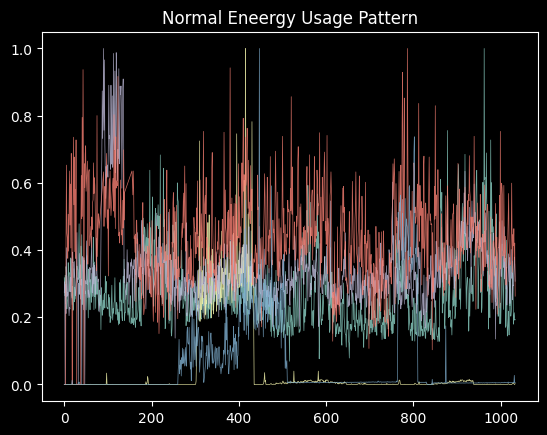

In [21]:
# Plot normal data for a customer

plt.grid()

for i in range(5):
    plt.plot(range(df_all_scaled.shape[1]-1), df_all_scaled[df_all_scaled['FLAG']==0].iloc[i,:-1], linewidth=0.5, alpha=0.8)

plt.gca().patch.set_facecolor('black') 
plt.title("Normal Eneergy Usage Pattern")
plt.grid(False)
plt.show()

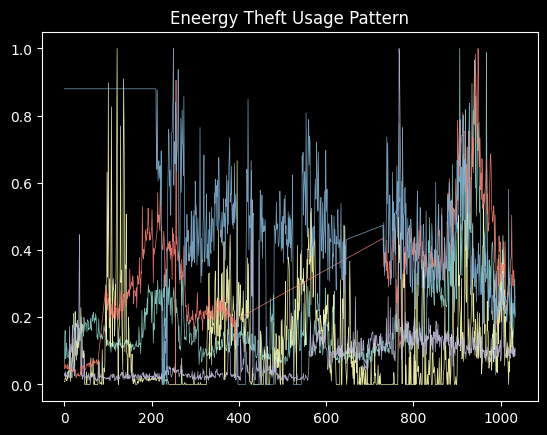

In [22]:
plt.grid()
for i in range(5):
    plt.plot(range(df_all_scaled.shape[1]-1), df_all_scaled[df_all_scaled['FLAG']==1].iloc[i,:-1], linewidth=0.5, alpha=0.9)

plt.gca().patch.set_facecolor('black') 
plt.title("Eneergy Theft Usage Pattern")
plt.grid(False)
plt.show()

In [23]:
del df, df_flag, df_theft, df_normal, df_all

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
from pyts.image import MarkovTransitionField
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms.functional import to_tensor
from torchvision.transforms.functional import to_grayscale

gaf = GramianAngularField(method='summation', image_size=224, sample_range=(-1,1))
gas = GramianAngularField(method='difference', image_size=224, sample_range=(-1,1))
mtf = MarkovTransitionField(image_size=224, n_bins = 2)


total = len(df_all_scaled)

dataset = []

for i in tqdm(range(total)):
    df_gaf = gaf.fit_transform(df_all_scaled.iloc[i:i+1,:-1]).astype('float32')
    df_gas = gas.fit_transform(df_all_scaled.iloc[i:i+1,:-1]).astype('float32')
    df_mtf = mtf.fit_transform(df_all_scaled.iloc[i:i+1,:-1]).astype('float32')
    # image = to_pil_image(np.array(df_all_scaled.iloc[i:i+1,]).astype('float32')).resize((224, 224))    
    # gaf_tensor = torch.Tensor(df_gaf)
    # gas_tensor = torch.Tensor(df_gas)
    # mtf_tensor = torch.Tensor(df_mtf)
    # dataset.append((gaf_tensor, gas_tensor, mtf_tensor, df_all_scaled.iloc[i:i+1,-1:]))
    dataset.append((df_gaf, df_gas, df_mtf, df_all_scaled.iloc[i:i+1,-1:]))

  0%|          | 0/4318 [00:00<?, ?it/s]

C:\Users\kkomo\AppData\Local\Temp\ipykernel_19680\2951815641.py:8: MatplotlibDeprecationWarning: The toggle_label function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use ax.tick_params and colorbar.set_label instead.
  ax.cax.toggle_label(True)


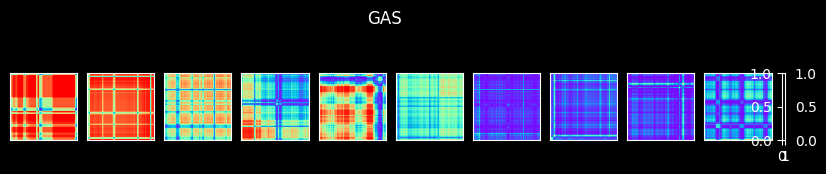

C:\Users\kkomo\AppData\Local\Temp\ipykernel_19680\2951815641.py:20: MatplotlibDeprecationWarning: The toggle_label function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use ax.tick_params and colorbar.set_label instead.
  ax.cax.toggle_label(True)


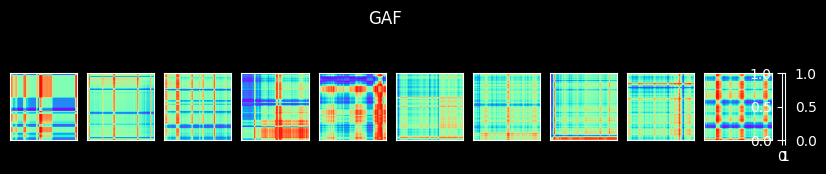

C:\Users\kkomo\AppData\Local\Temp\ipykernel_19680\2951815641.py:32: MatplotlibDeprecationWarning: The toggle_label function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use ax.tick_params and colorbar.set_label instead.
  ax.cax.toggle_label(True)


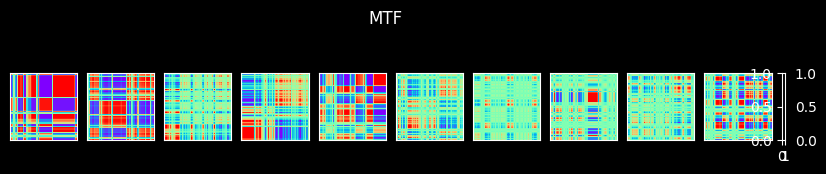

In [ ]:
fig = plt.figure(figsize=(10, 2))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 10), axes_pad=0.1, cbar_mode='single', share_all=True)
for i, ax in enumerate(grid):
    im = ax.imshow(dataset[i][0][0], cmap='rainbow', origin='lower')    
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
# plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)
fig.suptitle("GAS")
plt.show()


fig = plt.figure(figsize=(10, 2))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 10), axes_pad=0.1, cbar_mode='single', share_all=True)
for i, ax in enumerate(grid):
    im = ax.imshow(dataset[i][1][0], cmap='rainbow', origin='lower')    
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
# plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)
fig.suptitle("GAF")
plt.show()


fig = plt.figure(figsize=(10, 2))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 10), axes_pad=0.1, cbar_mode='single', share_all=True)
for i, ax in enumerate(grid):
    im = ax.imshow(dataset[i][2][0], cmap='rainbow', origin='lower')    
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
# plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)
fig.suptitle("MTF")
plt.show()


- ![Alt text](image-49.png)
- ![Alt text](image-50.png)
- ![Alt text](image-51.png)


In [ ]:
# split train, test dataset with 8:2 unsing normal random splitter of pytorch
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

splitter = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataset = splitter[0]
test_dataset = splitter[1]

# split train, validation dataset with 8:2 unsing normal random splitter of pytorch
train_size = int(len(train_dataset) * 0.8)
val_size = len(train_dataset) - train_size
splitter = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_dataset = splitter[0]
val_dataset = splitter[1]

print("size (train, val, test) = ({}, {}, {})".format( len(train_dataset), len(val_dataset), len(test_dataset))) 

size (train, val, test) = (2763, 691, 864)


In [ ]:
# Creating the dataset class
class EnergyData(Dataset):
    def __init__(self, datalist):
        listx = []
        listy = []
        for i in datalist:
            # listx.append(torch.cat([i[0], i[1], i[2]]))
            listx.append(np.vstack((i[0], i[1], i[2])))
            
            if i[3].values == 0:
                y = torch.tensor([1,0])
                listy.append(y.float())
                # print('yes', y)
            else:
                y = torch.tensor([0,1])
                listy.append(y.float())
                # print('else', y)
            
            # listy.append(torch.unsqueeze(torch.tensor(i[1]).float(), dim=0))           
            
        self.x = listx
        self.y = listy
        self.len = len(datalist)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.len


tr = EnergyData(train_dataset)
val = EnergyData(val_dataset)
ts = EnergyData(test_dataset)

del dataset

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device)) 

torch.manual_seed(45)
torch.cuda.manual_seed_all(45)

Using cuda device


In [ ]:
def print_losses(train_counter, train_losses, val_counter, val_losses, weight_decay, lr_rate):
    fig = plt.figure()
    plt.plot(train_counter, train_losses, label='Training Loss')
    plt.scatter(val_counter, val_losses, label='Validation Loss', color='red')
    plt.legend(['Training loss','Validation loss'], loc='upper right')
    plt.title('Training and Validation Loss(weight_decay = {}, lr = {})'.format(weight_decay, lr_rate))
    plt.ylabel('Cross Entropy Loss')
    fig.show()

In [ ]:
def train(model, tr_data, val_data, batch_size, lr_rate, 
          moment, weight_dec, num_of_epoch, logging_period):
    
    res_loss = {}

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr_rate, weight_decay=weight_dec)

    train_losses = []
    train_accuracy = []
    val_losses = []
    val_accuracy = []

    # List for plotting X-axis
    train_counter = []
    val_counter = []
   
    trainloader = DataLoader(tr_data, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    model.train()

    for epoch in tqdm(range(num_of_epoch), total=num_of_epoch):  # loop over the dataset multiple times

        epoch_loss = 0.0
        epoch_correct = 0    
        total = 0
        running_loss = 0.0   
        running_correct = 0 

        if epoch >= 10:
            lr = lr_rate * 0.5
            optimizer =  optim.SGD(model.parameters(), lr=lr, momentum=moment, weight_decay=weight_dec)

        for i, data in enumerate(trainloader):  
            
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels =  data[0].to(device), data[1].to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # inputs = transform(inputs)
            outputs = model(inputs)   

            loss = criterion(outputs, labels)        
            loss.backward()
            optimizer.step()

            sum_loss = loss.item() * len(labels)
            running_loss += sum_loss
            epoch_loss += sum_loss

            num_correct = torch.eq(torch.argmax(outputs, dim=1), torch.argmax(labels, dim=1)).int().sum().item()
            running_correct += num_correct
            epoch_correct += num_correct
            
            # print('Every batch loss: ', loss.item())
            # print('Running loss: ', running_loss)
            # print('Epoch loss: ', epoch_loss)
            # print('Every batch correct num: ', num_correct)
            # print('Running correct: ', running_correct)
            # print('Epoch correct: ', epoch_correct)

            # print('total: {}, i = {}'.format(total, i))
            
            total = total + len(labels)

            # print & accumulate training statistics (loss & accuracy) every 10 iterations
            if (i % logging_period == 0 and i>0):            
                avg_running_loss = running_loss / (batch_size * logging_period)
                avg_running_accuracy = 100. * running_correct / (batch_size * logging_period)  

                print('Epoch{} [{}/{} ({:.0f}%)]\t   avg.loss:{:.4f}   avg.accuracy:{:.4f}'
                    .format(epoch+1, i * len(labels), len(trainloader.dataset), 100. * i / len(trainloader), 
                            avg_running_loss, avg_running_accuracy))
                
                running_loss = 0.0   
                running_correct = 0 

                train_losses.append(avg_running_loss)
                train_accuracy.append(avg_running_accuracy)
                train_counter.append((epoch)*len(trainloader.dataset)+i*len(labels))    
            

        # print & accumulate val statistics (loss & accuracy)
        print('[Epoch {}] Train Loss: {:.4f} Train Accuracy: {:.4f}'.format(epoch + 1, 
                            epoch_loss / len(trainloader.dataset), 100. * epoch_correct / len(trainloader.dataset)), weight_dec, lr_rate)

        # Validation at the end of the epoch
        # set mode to eval mode & tell torch no gradients are required.
        model.eval()

        with torch.no_grad():   

            val_running_loss = 0.0
            val_correct = 0

            # loop through the data and find accuracy and loss for all val data
            for (inputs, labels) in valloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # inputs = transform(inputs)
                outputs = model(inputs) 
                
                val_correct += torch.eq(torch.argmax(outputs, dim=1), torch.argmax(labels, dim=1)).int().sum().item()
                # print('correct=', correct)
                loss = criterion(outputs, labels) 

                val_running_loss += loss.item() * len(labels)       

        val_losses.append(val_running_loss / len(valloader.dataset))
        val_accuracy.append(100. * val_correct / len(valloader.dataset))
        val_counter.append((epoch+1) * len(trainloader.dataset))

        print('\nValidation set: avg.loss: {:.4f},   avg.accuracy: {}/{} ({:.4f}%)\n'.format(
        val_running_loss / len(valloader.dataset), val_correct, len(valloader.dataset), 100. * val_correct / len(valloader.dataset)))
        
        # set the model back to train mode
        model.train()

        # print('Finished Training')
        print_losses(train_counter, train_losses, val_counter, val_losses)

        res_loss[weight_dec] = val_running_loss / len(valloader.dataset)

        return res_loss


c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


=============  Weight decay = 0.015, lr = 0.002 =============


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch1 [320/2763 (11%)]	   avg.loss:0.8880   avg.accuracy:55.0000
Epoch1 [640/2763 (23%)]	   avg.loss:0.8070   avg.accuracy:50.6250
Epoch1 [960/2763 (34%)]	   avg.loss:0.8289   avg.accuracy:48.4375
Epoch1 [1280/2763 (46%)]	   avg.loss:0.7853   avg.accuracy:48.7500
Epoch1 [1600/2763 (57%)]	   avg.loss:0.7899   avg.accuracy:49.3750
Epoch1 [1920/2763 (69%)]	   avg.loss:0.8508   avg.accuracy:46.2500
Epoch1 [2240/2763 (80%)]	   avg.loss:0.8072   avg.accuracy:50.6250
Epoch1 [2560/2763 (92%)]	   avg.loss:0.8123   avg.accuracy:49.6875
[Epoch 1] Train Loss: 0.8103 Train Accuracy: 49.3666


C:\Users\kkomo\AppData\Local\Temp\ipykernel_19680\1009293707.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
  0%|          | 0/15 [00:22<?, ?it/s]



Validation set: avg.loss: 0.8169,   avg.accuracy: 343/691 (49.6382%)

{0.015: 0.8168796918499142}
=============  Weight decay = 0.02, lr = 0.002 =============


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch1 [320/2763 (11%)]	   avg.loss:0.9187   avg.accuracy:51.5625
Epoch1 [640/2763 (23%)]	   avg.loss:0.8005   avg.accuracy:51.2500
Epoch1 [960/2763 (34%)]	   avg.loss:0.7977   avg.accuracy:50.9375
Epoch1 [1280/2763 (46%)]	   avg.loss:0.7867   avg.accuracy:52.1875
Epoch1 [1600/2763 (57%)]	   avg.loss:0.8019   avg.accuracy:50.9375
Epoch1 [1920/2763 (69%)]	   avg.loss:0.7975   avg.accuracy:50.0000
Epoch1 [2240/2763 (80%)]	   avg.loss:0.8320   avg.accuracy:48.1250
Epoch1 [2560/2763 (92%)]	   avg.loss:0.8227   avg.accuracy:49.0625
[Epoch 1] Train Loss: 0.8147 Train Accuracy: 49.4028


  0%|          | 0/15 [00:20<?, ?it/s]



Validation set: avg.loss: 0.8097,   avg.accuracy: 348/691 (50.3618%)

{0.02: 0.8096545182502736}
=============  Weight decay = 0.025, lr = 0.002 =============


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch1 [320/2763 (11%)]	   avg.loss:0.8711   avg.accuracy:56.5625
Epoch1 [640/2763 (23%)]	   avg.loss:0.8096   avg.accuracy:49.3750
Epoch1 [960/2763 (34%)]	   avg.loss:0.8041   avg.accuracy:48.4375
Epoch1 [1280/2763 (46%)]	   avg.loss:0.7717   avg.accuracy:51.8750
Epoch1 [1600/2763 (57%)]	   avg.loss:0.8164   avg.accuracy:49.6875
Epoch1 [1920/2763 (69%)]	   avg.loss:0.8175   avg.accuracy:48.4375
Epoch1 [2240/2763 (80%)]	   avg.loss:0.8507   avg.accuracy:46.2500
Epoch1 [2560/2763 (92%)]	   avg.loss:0.7745   avg.accuracy:53.1250
[Epoch 1] Train Loss: 0.7970 Train Accuracy: 50.6334


  0%|          | 0/15 [00:20<?, ?it/s]



Validation set: avg.loss: 0.6945,   avg.accuracy: 352/691 (50.9407%)

{0.025: 0.6945058563683727}
=============  Weight decay = 0.03, lr = 0.002 =============


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch1 [320/2763 (11%)]	   avg.loss:0.8942   avg.accuracy:54.6875
Epoch1 [640/2763 (23%)]	   avg.loss:0.7612   avg.accuracy:49.6875
Epoch1 [960/2763 (34%)]	   avg.loss:0.7798   avg.accuracy:51.5625
Epoch1 [1280/2763 (46%)]	   avg.loss:0.8373   avg.accuracy:46.2500
Epoch1 [1600/2763 (57%)]	   avg.loss:0.8179   avg.accuracy:48.4375
Epoch1 [1920/2763 (69%)]	   avg.loss:0.7873   avg.accuracy:52.5000
Epoch1 [2240/2763 (80%)]	   avg.loss:0.7662   avg.accuracy:51.8750
Epoch1 [2560/2763 (92%)]	   avg.loss:0.8139   avg.accuracy:49.3750
[Epoch 1] Train Loss: 0.7984 Train Accuracy: 49.9095


  0%|          | 0/15 [00:20<?, ?it/s]


Validation set: avg.loss: 0.8096,   avg.accuracy: 348/691 (50.3618%)

{0.03: 0.8096438020079595}


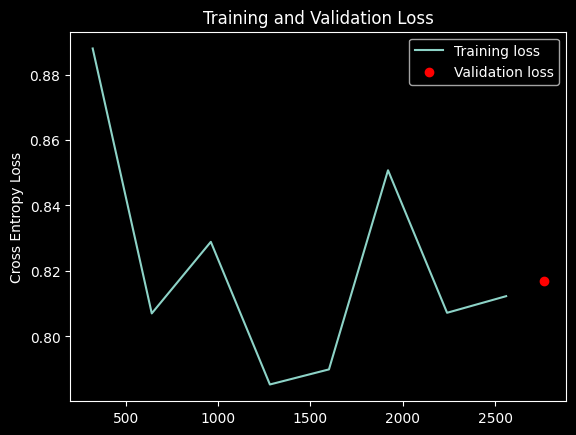

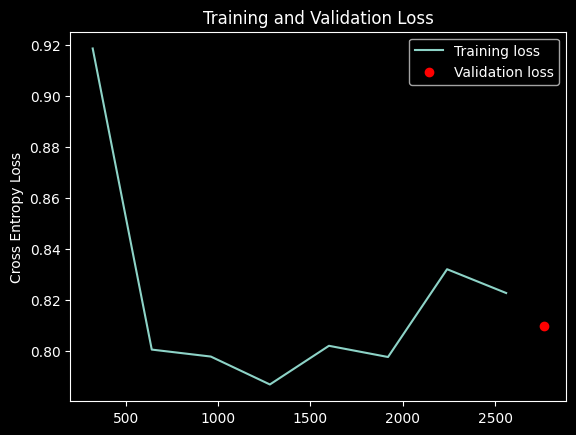

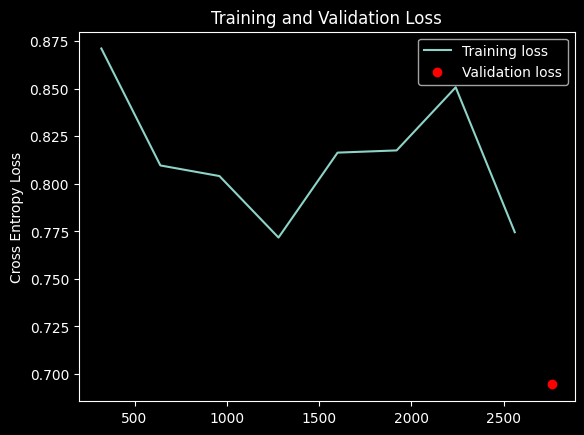

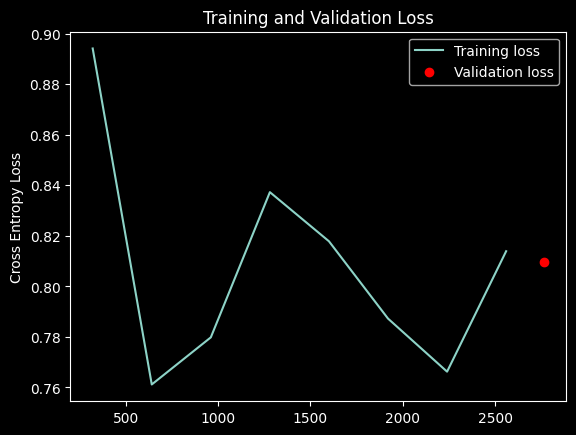

In [ ]:
# model = models.resnet18(pretrained=True)
# for param in model.parameters():   
#     param.requires_grad = False
# model.fc = nn.Sequential(
#     nn.Linear(model.fc.in_features, out_features=256, bias=True),
#     nn.ReLU(inplace=True),
#     nn.Dropout(p=0.5, inplace=False),
#     nn.Linear(in_features=256, out_features=2, bias=True),
#     nn.Softmax()
#     )

model =  models.vgg16(pretrained=True)
for param in model.parameters():   
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True
model.classifier[6] = nn.Sequential(
    nn.Linear(in_features = model.classifier[6].in_features, out_features = 2, bias = True),
    nn.Softmax(dim=1)
)

lr_rate = 0.002
moment = 0.9
weight_dec = [0.015, 0.02, 0.025, 0.03]
num_of_epoch = 15
batch_size = 32
logging_period = 10
# criterion = nn.CrossEntropyLoss()
# optimizer =  optim.SGD(model.parameters(), lr=lr_rate, momentum=moment, weight_decay=weight_dec)

for weight in weight_dec:
    print('=============  Weight decay = {}, lr = {} ============='.format(weight, lr_rate))    
    res_loss = train(model, tr, val, batch_size, lr_rate, moment, weight, num_of_epoch, logging_period)
    print(res_loss)

Test accuracy: 50.0000 (50.0/864)


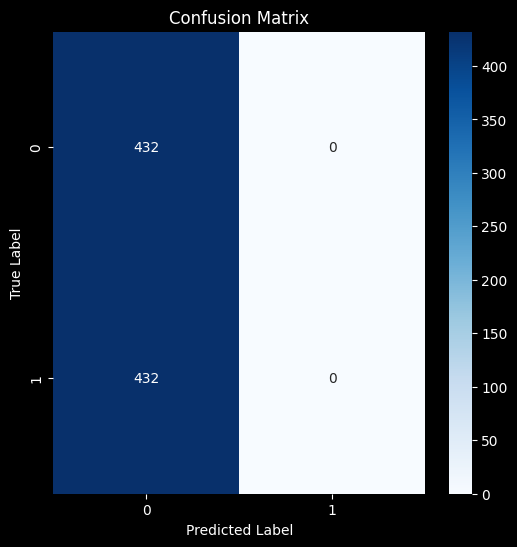

Recall: 0.0000
Precision: 0.0000
F1 Score: 0.0000
Accuracy: 0.5000


c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score
import seaborn as sns

y_true = []
y_pred = []

model.eval()

with torch.no_grad():
    
    test_correct = 0

    testloader = DataLoader(ts, batch_size=batch_size)

    for (inputs, labels) in testloader:
       inputs = inputs.to(device)
       labels = labels.to(device)

       # inputs = transform(inputs)       
       outputs = model(inputs)
       
       test_correct += torch.eq(torch.argmax(outputs, dim=1), torch.argmax(labels, dim=1)).int().sum().item()

       y_true.extend(torch.argmax(labels, dim=1).cpu().numpy())  # Move labels to CPU and convert to numpy
       y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())   # Move preds to CPU and convert to numpy
     
      
    accuracy_test = 100. * test_correct / len(testloader.dataset)

    print('Test accuracy: {:.4f} ({}/{})'.format(accuracy_test, accuracy_test, len(testloader.dataset)))


# Find and plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print F1 score
rec_score = recall_score(y_true, y_pred)
print('Recall: {:.4f}'.format(rec_score))

pre_score = precision_score(y_true, y_pred)
print('Precision: {:.4f}'.format(pre_score))

f1 = f1_score(y_true, y_pred)
print('F1 Score: {:.4f}'.format(f1))

acc_score = accuracy_score(y_true, y_pred)
print('Accuracy: {:.4f}'.format(acc_score))

# Result archiving

# VGG16 decay 0.02 epch 20

model =  models.vgg16(pretrained=True)
for param in model.parameters():   
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True
model.classifier[6] = nn.Sequential(
    nn.Linear(in_features = model.classifier[6].in_features, out_features = 2, bias = True),
    nn.Softmax(dim=1)
)

lr_rate = 0.002
moment = 0.9
weight_dec = 0.02

num_of_epoch = 20
batch_size = 32

model = model.to(device)
class_weights = torch.Tensor([0.5, 0.5]).to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer =  optim.SGD(model.parameters(), lr=lr_rate, momentum=moment, weight_decay=weight_dec)

![Alt text](image-58.png)

![Alt text](image-59.png)

Recall: 0.6957
Precision: 0.7042
F1 Score: 0.6999
Accuracy: 0.7141

# VGG16 wdecay 0.02 eopch 10

model =  models.vgg16(pretrained=True)
for param in model.parameters():   
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True
model.classifier[6] = nn.Sequential(
    nn.Linear(in_features = model.classifier[6].in_features, out_features = 2, bias = True),
    nn.Softmax(dim=1)
)

lr_rate = 0.002
moment = 0.9
weight_dec = 0.02

num_of_epoch = 10
batch_size = 32

model = model.to(device)
class_weights = torch.Tensor([0.5, 0.5]).to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer =  optim.SGD(model.parameters(), lr=lr_rate, momentum=moment, weight_decay=weight_dec)


![Alt text](image-56.png)


![Alt text](image-57.png)

Recall: 0.7705
Precision: 0.6674
F1 Score: 0.7152
Accuracy: 0.7060

## VGG16 

model =  models.vgg16(pretrained=True)
for param in model.parameters():   
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True
model.classifier[6] = nn.Sequential(
    nn.Linear(in_features = model.classifier[6].in_features, out_features = 2, bias = True),
    nn.Softmax(dim=1)
)

lr_rate = 0.002
moment = 0.9
weight_dec = 0.01

num_of_epoch = 10
batch_size = 32

model = model.to(device)
class_weights = torch.Tensor([0.5, 0.5]).to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer =  optim.SGD(model.parameters(), lr=lr_rate, momentum=moment, weight_decay=weight_dec)

![Alt text](image-54.png)

![Alt text](image-55.png)

Recall: 0.6872
Precision: 0.6277
F1 Score: 0.6561
Accuracy: 0.6481